<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/component-1/Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
data_dir = "D:/Data1_Split"
train_dir = os.path.join(data_dir, "Train")
val_dir = os.path.join(data_dir, "Validation")
test_dir = os.path.join(data_dir, "Test")

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=(0.8, 1.3),
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)


In [ ]:
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Found 4931 images belonging to 2 classes.
Found 1056 images belonging to 2 classes.
Found 1059 images belonging to 2 classes.
Class Weights: {0: 0.9661050156739812, 1: 1.0363598150483397}


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.7472 - auc_1: 0.8117 - loss: 0.5445 - val_accuracy: 0.7358 - val_auc_1: 0.9429 - val_loss: 0.6066 - learning_rate: 1.0000e-04
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 836s 5s/step - accuracy: 0.8175 - auc_1: 0.8684 - loss: 0.4770 - val_accuracy: 0.9072 - val_auc_1: 0.9472 - val_loss: 0.5206 - learning_rate: 1.0000e-04
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 2391s 16s/step - accuracy: 0.8245 - auc_1: 0.8725 - loss: 0.4647 - val_accuracy: 0.6307 - val_auc_1: 0.9475 - val_loss: 0.5122 - learning_rate: 1.0000e-04
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8243 - auc_1: 0.8788 - loss: 0.4508 - val_accuracy: 0.9214 - val_auc_1: 0.9506 - val_loss: 0.3936 - learning_rate: 1.0000e-04
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.8497 - auc_1: 0.8868 - loss: 0.4392 - val_accuracy: 0.8835 - val_auc_1: 0.9537 - val_loss: 0.3681 - learning_rate: 1.0000e-04
Epoch 6/15
155/155 ━━━━━━━━━━━━━━

Model saved as fundus_improved_classifier.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step
Optimal Threshold: 0.4321

Classification Report:
              precision    recall  f1-score   support

   No Fundus       0.94      0.98      0.96       548
      Fundus       0.98      0.93      0.95       511

    accuracy                           0.96      1059
   macro avg       0.96      0.96      0.96      1059
weighted avg       0.96      0.96      0.96      1059



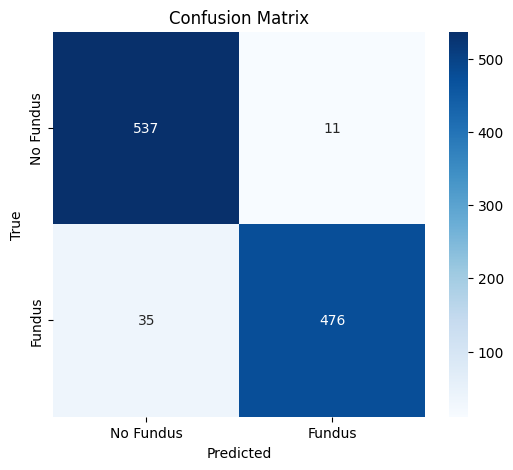

In [ ]:
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4),
              loss=BinaryCrossentropy(label_smoothing=0.05),
              metrics=["accuracy", tf.keras.metrics.AUC()])

early_stop = EarlyStopping(patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.2, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

base_model.trainable = True
fine_tune_at = len(base_model.layers) - 40

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5),
              loss=BinaryCrossentropy(label_smoothing=0.05),
              metrics=["accuracy", tf.keras.metrics.AUC()])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

model.save("fundus_improved_classifier_new.h5")
print("Model saved as fundus_improved_classifier.h5")

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator).flatten()


fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")
       
y_pred = (y_pred_probs > optimal_threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No Fundus", "Fundus"]))


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fundus", "Fundus"],
            yticklabels=["No Fundus", "Fundus"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [37]:
print("Class label mapping:", train_generator.class_indices)


Class label mapping: {'Fundus': 0, 'Non Fundus': 1}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

In [28]:
MODEL_PATH = "fundus_improved_classifier_new.h5"
IMG_PATH = r"C:\Users\User\Downloads\download (27).jpeg" 
print("Loading model...")
model = load_model(MODEL_PATH)

Loading model...


In [29]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0), img

img_array, original_img = load_and_preprocess_image(IMG_PATH)
prediction_prob = model.predict(img_array)[0][0]

label = "Non Fundus" if prediction_prob > 0.5 else "Fundus"
confidence = prediction_prob if prediction_prob > 0.5 else 1 - prediction_prob

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


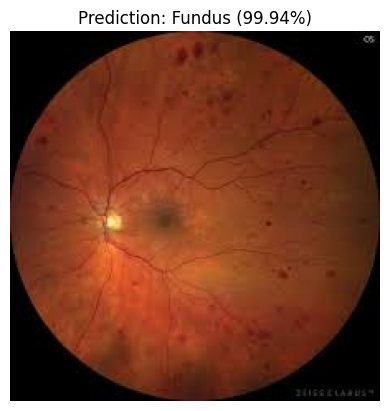

In [30]:
plt.imshow(original_img)
plt.axis("off")
plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
plt.show()
